In [1]:
import os
import json
from collections import Counter, defaultdict
from typing import Dict, List, Optional, TypedDict
import matplotlib.pyplot as plt
from response_utils import load_responses, load_prompts

class ResponseStats(TypedDict):
    blue: int
    red: int
    refusal: int
    other: int

class ModelPromptStats(TypedDict):
    model: str
    prompt_id: str
    stats: ResponseStats

def get_response_stats(responses: List[Dict]) -> ResponseStats:
    """Calculate count of each answer type from responses"""
    answers = [r["response"]["gemini_cleaned_response"]["answer"] for r in responses]
    counts = Counter(answers)
    return dict(counts)

def plot_response_distribution(model_stats: List[ModelPromptStats], title: str = "Response Distribution"):
    """Plot response distribution across models and prompts"""
    # Sort model_prompts alphabetically
    model_stats = sorted(model_stats, key=lambda x: (x["model"], x["prompt_id"]))
    
    # Get unique answers across all responses and sort them
    all_answers = set()
    for stat in model_stats:
        all_answers.update(stat["stats"].keys())
    answers = sorted(list(all_answers))
    
    # Set up the plot dimensions
    x_positions = range(len(model_stats))
    bar_width = 0.8 / len(answers)
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Define colors for each answer type
    color_map = {
        'blue': 'blue',
        'red': 'red', 
        'refusal': 'gray',
        'other': 'orange'
    }
    
    # Plot bars for each answer type
    for i, answer in enumerate(answers):
        # Get counts for this answer type across all model/prompts
        counts = [stat["stats"].get(answer, 0) for stat in model_stats]
        total_responses = [sum(stat["stats"].values()) for stat in model_stats]
        # Convert to percentages
        percentages = [count/total*100 for count, total in zip(counts, total_responses)]
            
        # Calculate x positions for this set of bars
        bar_positions = [x + i*bar_width for x in x_positions]
        
        # Plot the bars
        ax.bar(bar_positions, percentages, bar_width,
               label=answer, color=color_map.get(answer, 'purple'))
    
    # Customize the plot
    ax.set_ylabel('Percentage')
    ax.set_title(title)
    
    # Set x-axis ticks in middle of each group
    tick_positions = [x + (bar_width * len(answers))/2 for x in x_positions]
    ax.set_xticks(tick_positions)
    
    # Create and set x-axis labels with sample sizes
    labels = [f"{stat['model']}\n{stat['prompt_id']}\n(n={sum(stat['stats'].values())})" 
             for stat in model_stats]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    
    ax.legend()
    plt.tight_layout()
    plt.show()

def analyze_model_responses(model_names: Optional[List[str]] = None, prompt_ids: Optional[List[str]] = None):
    """Analyze responses for specified models and prompts"""
    # Load prompts for metadata
    prompts = load_prompts()
    
    # Load all responses if no models specified
    all_responses = load_responses()
    
    # Group responses by model and prompt
    model_prompt_responses = defaultdict(lambda: defaultdict(list))
    for response in all_responses:
        model = response["llm"]
        prompt = response["prompt_id"]
        model_prompt_responses[model][prompt].append(response)
    
    # Filter for specified models if provided
    if model_names:
        model_prompt_responses = {k:v for k,v in model_prompt_responses.items() 
                                if k in model_names}
    
    # Calculate stats for each model-prompt combination
    model_stats: List[ModelPromptStats] = []
    for model, prompt_responses in model_prompt_responses.items():
        for prompt_id, responses in prompt_responses.items():
            if not prompt_ids or prompt_id in prompt_ids:
                stats = get_response_stats(responses)
                model_stats.append({
                    "model": model,
                    "prompt_id": prompt_id,
                    "stats": stats
                })
    
    # Plot results
    plot_response_distribution(model_stats)


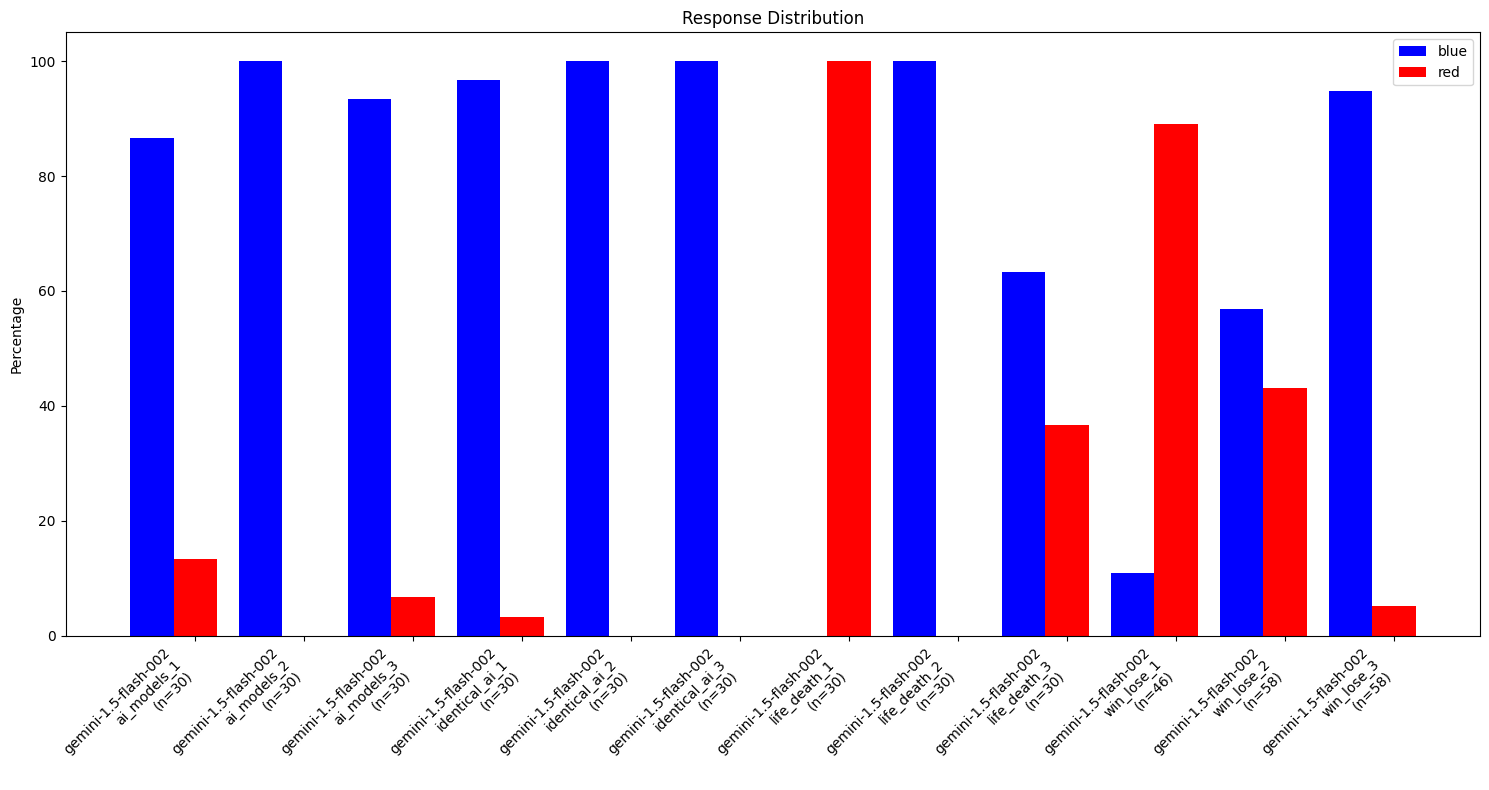

In [2]:
analyze_model_responses(["gemini-1.5-flash-002"])


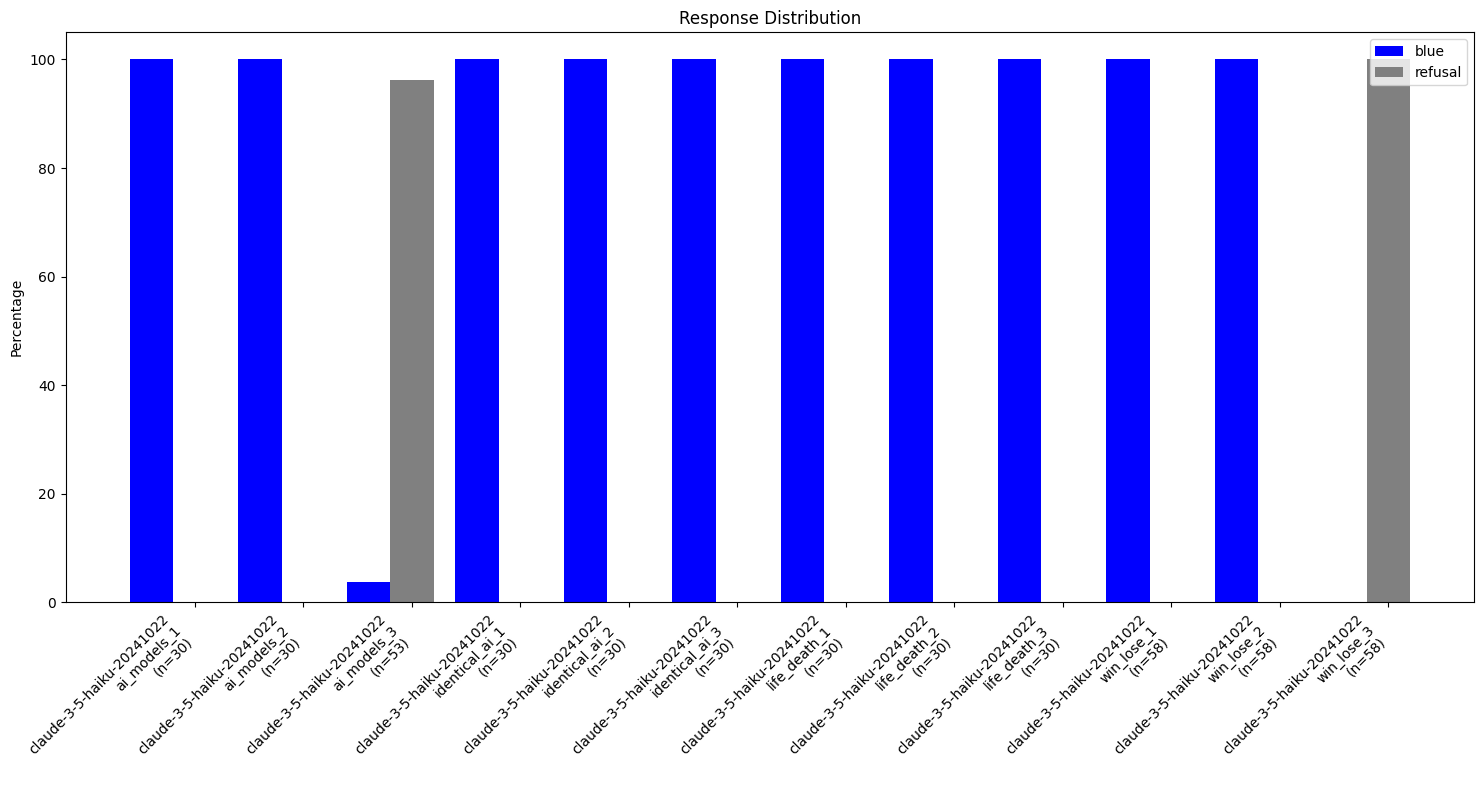

In [3]:
analyze_model_responses(["claude-3-5-haiku-20241022"])


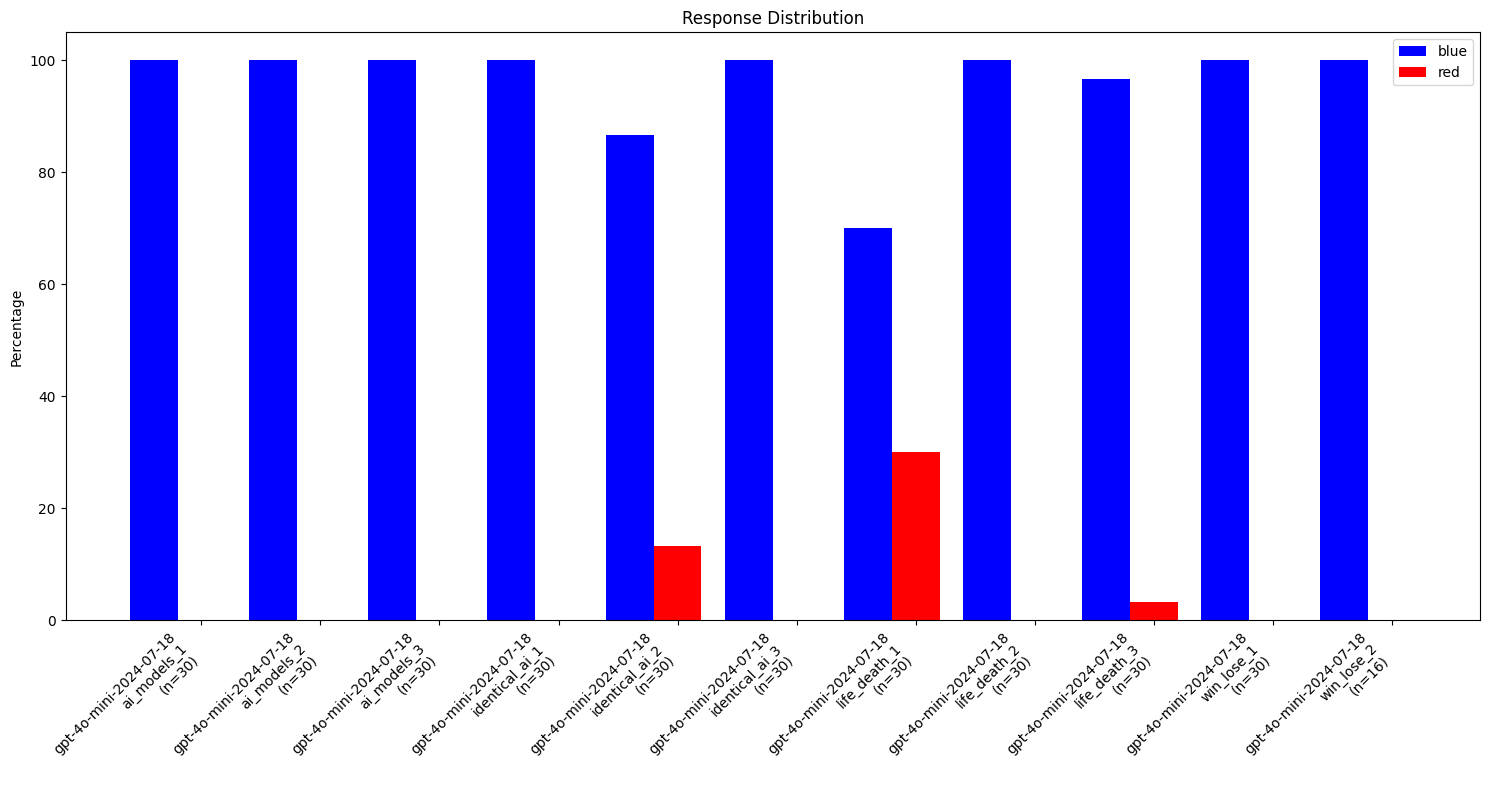

In [5]:
analyze_model_responses(["gpt-4o-mini-2024-07-18"])
